cifar2数据集为cifar10数据集的子集，只包括前两种类别airplane和automobile。

训练集有airplane和automobile图片各5000张，测试集有airplane和automobile图片各1000张。

cifar2任务的目标是训练一个模型来对飞机airplane和机动车automobile两种图片进行分类。

在tensorflow中准备图片数据的常用方案有两种:
    
第一种是使用tf.keras中的ImageDataGenerator工具构建图片数据生成器。
参考https://zhuanlan.zhihu.com/p/67466552

第二种是使用tf.data.Dataset搭配tf.image中的一些图片处理方法构建数据管道。
TensorFlow的原生方法，更加灵活，使用得当的话也可以获得更好的性能。

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

BATCH_SIZE = 100
tmp = None
def load_image(img_path, size=(32,32)):  # 加载并处理图片
    # automobile的标注为1，airplane的标注为0  # windows下要将".*/automobile/.*"改为".*automobile.*"
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*automobile.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)  # 从路径中读取图片
    img = tf.image.decode_jpeg(img)  # 把JPEG格式的图片解码
    img = tf.image.resize(img, size)/255.0  # 调整尺寸为size,再把像素调整到0~1之间
    return (img,label)

In [2]:
#使用并行化预处理num_parallel_calls 和预存数据prefetch来提升性能 shuffle:洗牌
ds_train = tf.data.Dataset.list_files(".\\data\\cifar2\\train\\*\\*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

ds_test = tf.data.Dataset.list_files(".\\data\\cifar2\\test\\*\\*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)

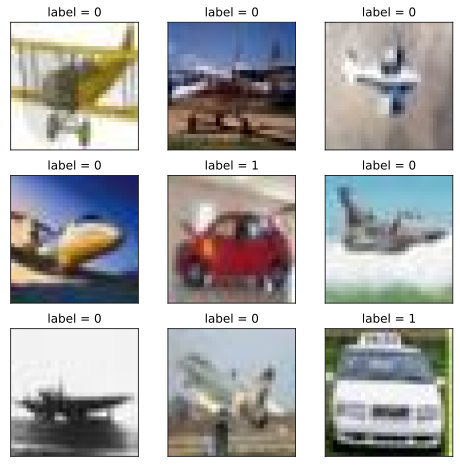

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

二，定义模型

In [4]:
# 此处选择使用函数式API构建模型。
tf.keras.backend.clear_session() #清空会话

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs,outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0     

三，训练模型

In [5]:
import datetime
# Linux:logdir = "./data/keras_model/"
logdir = ".\\data\\keras_model\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# 设置回调
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# 编译模型
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=["accuracy"]
    )
# 使用fit方法
history = model.fit(ds_train,epochs= 10,validation_data=ds_test,
                    callbacks = [tensorboard_callback],workers = 4)

Train for 100 steps, validate for 20 steps
Epoch 1/10
100/100 [==============================] - 5s 46ms/step - loss: 0.4404 - accuracy: 0.7853 - val_loss: 0.3288 - val_accuracy: 0.8590
Epoch 2/10
100/100 [==============================] - 3s 26ms/step - loss: 0.3175 - accuracy: 0.8644 - val_loss: 0.2704 - val_accuracy: 0.8830
Epoch 3/10
100/100 [==============================] - 3s 25ms/step - loss: 0.2641 - accuracy: 0.8917 - val_loss: 0.2206 - val_accuracy: 0.9100
Epoch 4/10
100/100 [==============================] - 3s 25ms/step - loss: 0.2184 - accuracy: 0.9140 - val_loss: 0.1980 - val_accuracy: 0.9210
Epoch 5/10
100/100 [==============================] - 3s 25ms/step - loss: 0.1865 - accuracy: 0.9276 - val_loss: 0.1800 - val_accuracy: 0.9200
Epoch 6/10
100/100 [==============================] - 3s 25ms/step - loss: 0.1633 - accuracy: 0.9367 - val_loss: 0.1740 - val_accuracy: 0.9305
Epoch 7/10
100/100 [==============================] - 3s 25ms/step - loss: 0.1460 - accuracy: 0.944

四，评估模型

In [6]:
#%load_ext tensorboard
#%tensorboard --logdir ./data/keras_model
from tensorboard import notebook
notebook.list()
#在tensorboard中查看模型
# notebook.start("--logdir ./data/keras_model") # Linux
notebook.start("--logdir .\\data\\keras_model")

Known TensorBoard instances:
  - port 6006: logdir .datakeras_model (started 1:31:50 ago; pid 10056)
  - port 6006: logdir ./data/keras_model (started 1:32:27 ago; pid 13544)


Reusing TensorBoard on port 6006 (pid 10056), started 1:31:50 ago. (Use '!kill 10056' to kill it.)

In [7]:
import pandas as pd 
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1,len(dfhistory) + 1)
dfhistory.index.name = 'epoch'

dfhistory

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,0.440391,0.7853,0.328771,0.8590
2,0.317512,0.8644,0.270357,0.8830
3,0.264057,0.8917,0.220576,0.9100
4,0.218364,0.9140,0.197990,0.9210
5,0.186548,0.9276,0.180027,0.9200
6,0.163309,0.9367,0.173970,0.9305
7,0.145996,0.9446,0.190442,0.9280
8,0.132437,0.9497,0.174910,0.9290
9,0.113806,0.9555,0.168556,0.9285


In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

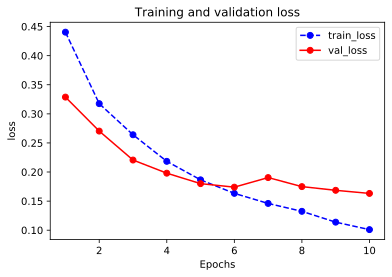

In [9]:
plot_metric(history,"loss")

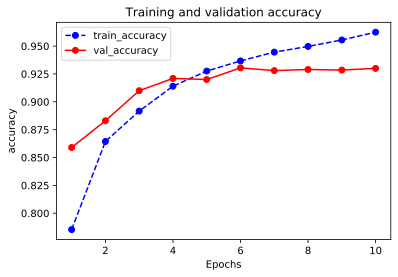

In [10]:
plot_metric(history,"accuracy")

In [11]:
#可以使用evaluate对数据进行评估
val_loss,val_accuracy = model.evaluate(ds_test,workers=4)
print(val_loss,val_accuracy)

20/20 [==============================] - 0s 20ms/step - loss: 0.1632 - accuracy: 0.9300
0.16319990679621696 0.93


六，保存模型

In [12]:
# 保存权重，该方式仅仅保存权重张量
model.save_weights('./data/tf_model_weights.ckpt',save_format = "tf")
# 保存模型结构与模型参数到文件,该方式保存的模型具有跨平台性便于部署

model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_loaded.evaluate(ds_test)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel\assets
export saved model.
20/20 [==============================] - 0s 23ms/step - loss: 0.1632 - accuracy: 0.9300


[0.16319969855248928, 0.93]